# Arsenic Contamination Example

This example demonstrates how to add a simple arsenic contamination event to a scenario.

[EPyT-Flow](https://github.com/WaterFutures/EPyT-Flow) is available on [PyPI](https://pypi.org/project/epyt-flow/) and can be installed via `pip install epyt-flow`:

In [ ]:
# %pip install epyt-flow --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
from epyt_flow.data.benchmarks import load_leakdb_scenarios
from epyt_flow.simulation import ScenarioSimulator, EpanetConstants, ScenarioConfig
from epyt_flow.simulation.events import SpeciesInjectionEvent
from epyt_flow.utils import to_seconds

Create a new scenario based on the first Net1 [LeakDB](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.data.benchmarks.html#module-epyt_flow.data.benchmarks.leakdb) scenario -- we also add an additional EPANET-MSX configuration file `arsenic_contamination.msx`:

In [3]:
config, = load_leakdb_scenarios(scenarios_id=["1"], use_net1=True, verbose=False, download_dir="")
config = ScenarioConfig(scenario_config=config,
                        f_msx_in="arsenic_contamination.msx")

In [4]:
# sim = ScenarioSimulator(scenario_config=config)

# sim.epanet_api.settimeparam(EpanetConstants.EN_PATTERNSTEP, sim.get_hydraulic_time_step())

# sim.save_to_epanet_file(config.f_inp_in)

# sim.close()


In [5]:
sim = ScenarioSimulator(scenario_config=config)

In [6]:
# sim.plot_topology()


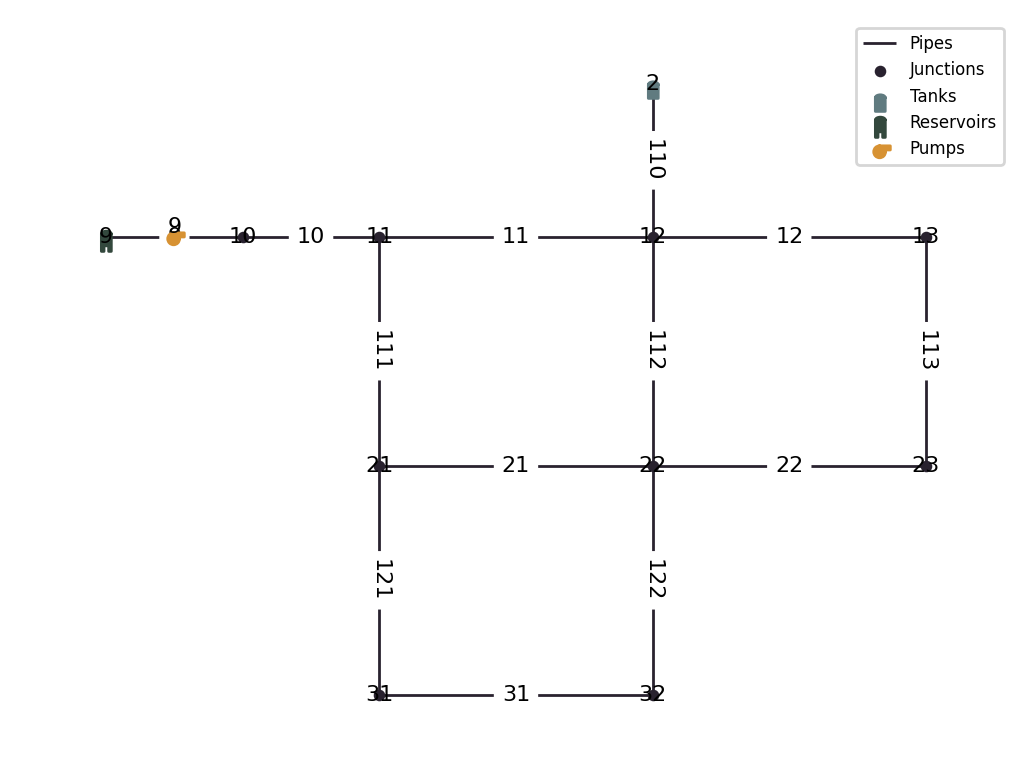

In [7]:
from epyt_flow.visualization import ScenarioVisualizer
vis = ScenarioVisualizer(sim)
vis.add_labels('all')
vis.show_plot()

In [8]:
topo = sim.get_topology()

print(topo.nodes)
print(topo.edges)


['10', '11', '12', '13', '21', '22', '23', '31', '32', '9', '2']
[('10', '11'), ('10', '9'), ('11', '12'), ('11', '21'), ('12', '13'), ('12', '2'), ('12', '22'), ('13', '23'), ('21', '22'), ('21', '31'), ('22', '23'), ('22', '32'), ('31', '32')]


In [9]:
# Show information associated with node "2"
print(topo.get_node_info("2"))

{'elevation': 259.0799865722656, 'coord': [50.0, 90.0], 'comment': '', 'type': 2, 'base_demand': 0.0, 'diameter': 15.392399787902832, 'max_level': 45.720001220703125, 'min_level': 30.479999542236328, 'min_vol': 5671.755859375, 'mixing_fraction': 1.0, 'mixing_model': 0, 'init_vol': 6806.10693359375, 'cylindric': True, 'can_overflow': False, 'vol_curve_id': ''}


Set simulation duration to 21 days by calling [set_general_parameters()](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.simulation.html#epyt_flow.simulation.scenario_simulator.ScenarioSimulator.set_general_parameters) -- note that all time durations have to be stated in seconds, the function [to_seconds()](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.html#epyt_flow.utils.to_seconds) can convert minutes/hours/days to seconds:

In [10]:
sim.set_general_parameters(simulation_duration=to_seconds(days=21))

Place some chlorine sensors and also keep track of the contaminant:

In [11]:
cl_sensor_locations = ["10", "11", "12", "13", "21", "22", "23", "31", "32"]
all_nodes = sim.sensor_config.nodes

sim.set_bulk_species_node_sensors({"Chlorine": cl_sensor_locations,
                                   # Also: Keep track of the contaminant
                                   "AsIII": all_nodes})   # Arsenite

Create a 1-day contamination event of an Arsenite injection (100 mg/day) at node "22" by creating a new instance of the [SpeciesInjectionEvent](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.simulation.events.html#epyt_flow.simulation.events.quality_events.SpeciesInjectionEvent) class and calling [add_system_event()](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.simulation.html#epyt_flow.simulation.scenario_simulator.ScenarioSimulator.add_system_event):

In [12]:
# contamination_event = SpeciesInjectionEvent(species_id="AsIII", node_id="22",
#                                     profile=np.array([10000000]),
#                                     source_type=EpanetConstants.EN_MASS,
#                                     start_time=to_seconds(days=5),
#                                     end_time=to_seconds(days=9))

# sim.add_system_event(contamination_event)

In [13]:
import random

possible_nodes = ['10', '11', '12', '13', '21', '22', '23', '31', '32']

species = "AsIII"
contamination_node = random.choice(possible_nodes)
start_day = random.randint(0, 7)  
duration_days = random.randint(1, 5)  
injection_amount = random.randint(1, 1000000)
source_type = EpanetConstants.EN_MASS


def generate_contamination_event(species, contamination_node, injection_amount, source_type, start_day, duration_days):
    """
    Function to generate a contamination event, which consists of an injection of a species at a node in the network.
    The contamination event is defined as an injection of a species at a specific node in the network, with a specified profile and duration.

    Parameters:
    species: id of the species being injected
    contamination_node: node id where the contamination occurs
    start_day: day of the start of the contamination event 
    duration_days: duration of the contamination event in days 
    injection_amount: amount of species injected 

    Returns:
    contamination_event: a SpeciesInjectionEvent object that represents the contamination event

    """
    
    contamination_event = SpeciesInjectionEvent(
        species_id=species,
        node_id=contamination_node,
        profile=np.array([injection_amount]),
        source_type=source_type,
        start_time=to_seconds(days=start_day),
        end_time=to_seconds(days=start_day + duration_days)
    )

    return contamination_event


event = generate_contamination_event(species, contamination_node, injection_amount, source_type, start_day, duration_days)
print(f"Generated contamination event: {event}")
sim.add_system_event(event)

Generated contamination event: start_time: 604800 end_time: 777600 species_id: AsIII node_id: 12 profile: [405028] source_type: 1


Run the entire simulation by calling [run_simulation()](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.simulation.html#epyt_flow.simulation.scenario_simulator.ScenarioSimulator.run_simulation):

In [14]:
scada_data = sim.run_simulation()

c:\Users\genot\OneDrive - Université de Namur\Documents\AI-for-Drinking-Water-Chlorination-Challenge-IJCAI-25\venv\lib\site-packages\epyt_flow\simulation\scenario_simulator.py:2954: UserWarning: Failed to remove temporary file 'C:\Users\genot\AppData\Local\Temp\epytflow_MSX_07df86f5-6a46-4a23-9d4f-fb5fe98cfc7e.hyd'
  warnings.warn(f"Failed to remove temporary file '{hyd_export}'")


Inspect simulation results -- i.e. plot sensor readings over time by calling the [plot_bulk_species_node_concentration](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.simulation.scada.html#epyt_flow.simulation.scada.scada_data.ScadaData.plot_bulk_species_node_concentration) function:

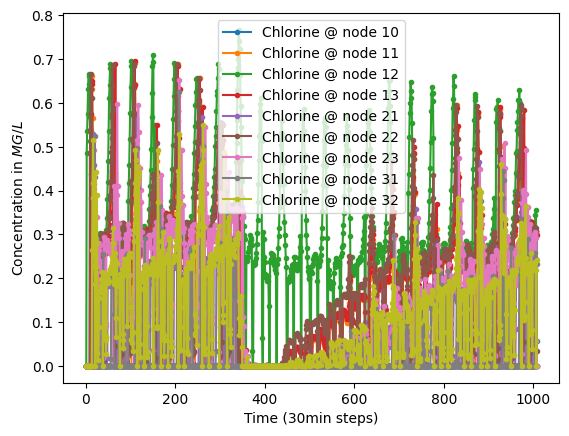

<Axes: xlabel='Time (30min steps)', ylabel='Concentration in $MG/L$'>

In [15]:
scada_data.plot_bulk_species_node_concentration({"Chlorine": cl_sensor_locations})

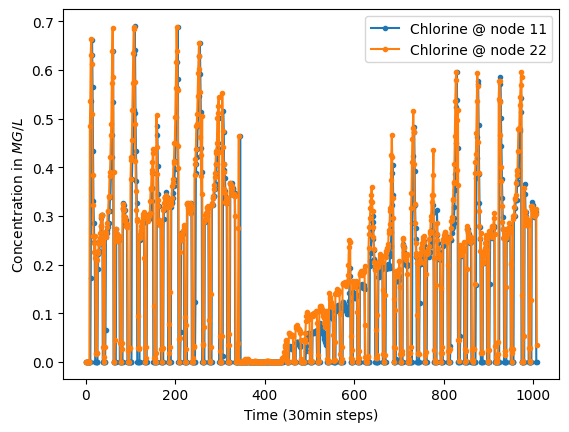

<Axes: xlabel='Time (30min steps)', ylabel='Concentration in $MG/L$'>

In [16]:
scada_data.plot_bulk_species_node_concentration({"Chlorine": ["11","22"]})

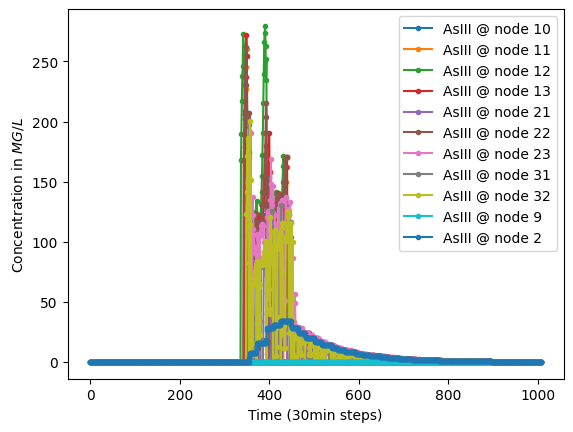

<Axes: xlabel='Time (30min steps)', ylabel='Concentration in $MG/L$'>

In [17]:
scada_data.plot_bulk_species_node_concentration({"AsIII": all_nodes})

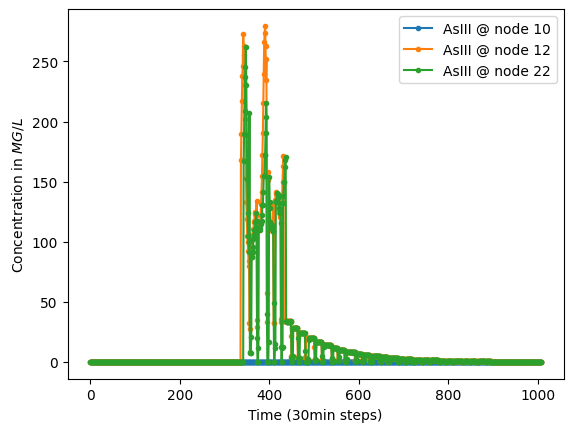

<Axes: xlabel='Time (30min steps)', ylabel='Concentration in $MG/L$'>

In [18]:
scada_data.plot_bulk_species_node_concentration({"AsIII": ["10","12","22"]})

In [ ]:
# Export SCADA results 
# scada_data.to_numpy_file("scada_data.npz", export_raw_data=False)
df = scada_data.to_pandas_dataframe(export_raw_data=False)
df.to_csv("scada_data.csv", index=False)


Do not forget to close the simulation by calling [close()](https://epyt-flow.readthedocs.io/en/stable/epyt_flow.simulation.html#epyt_flow.simulation.scenario_simulator.ScenarioSimulator.close):

In [20]:
sim.close()